In [3]:
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pickle
import copy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import xgboost as xgb
import pprint

In [4]:
import zipfile
outer_zip_path = '/content/nyc-taxi-trip-duration.zip'
extraction_dir = '/content/nyc-taxi-trip-duration'
import os
os.makedirs(extraction_dir, exist_ok=True)
with zipfile.ZipFile(outer_zip_path, 'r') as zip_ref:
  zip_ref.extractall(extraction_dir)

import glob
inner_zip_files = glob.glob(f'{extraction_dir}/**/*.zip', recursive=True)

for inner_zip_path in inner_zip_files:
    # Define an extraction directory for each inner zip file (optional, or extract to a common location)
    inner_extraction_dir = os.path.join(os.path.dirname(inner_zip_path), os.path.basename(inner_zip_path).replace('.zip', ''))
    os.makedirs(inner_extraction_dir, exist_ok=True)

    with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
        zip_ref.extractall(inner_extraction_dir)
    print(f"Extracted: {inner_zip_path} to {inner_extraction_dir}")

Extracted: /content/nyc-taxi-trip-duration/test.zip to /content/nyc-taxi-trip-duration/test
Extracted: /content/nyc-taxi-trip-duration/train.zip to /content/nyc-taxi-trip-duration/train
Extracted: /content/nyc-taxi-trip-duration/sample_submission.zip to /content/nyc-taxi-trip-duration/sample_submission


In [5]:
filename = "/content/xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
geolocator = Nominatim(user_agent="aco-application")

In [6]:
def time_cost_between_points(loc1, loc2, passenger_count, store_and_fwd_flag=0):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """
    # Hardcode the date to get consistent calculations
    date_list = [27, 5, 2016]  # May 27, 2016

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': bool(store_and_fwd_flag),
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 11,
                  'pickup_minute': 0,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]

In [7]:
def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))

In [8]:
def total_cost_from_path(path):
    """
    Calculate the time (in minutes) to travel a path
    using the trained XGB model
    """
    total_cost = 0
    for i in range(1, len(path)):
        j = i - 1
        total_cost += cost_matrix[path[j]][path[i]]
    # Find time it takes to go back to original location
    total_cost += cost_matrix[path[-1]][path[0]]
    return total_cost

In [14]:
import argparse
import sys

# Simulate command-line arguments in Colab
sys.argv = ['script_name', '15', '10', '100', '0.5', '0.7', '--verbose']

# Read in user input
parser = argparse.ArgumentParser()
parser.add_argument("loc_count", type=int,
                    help="number of locations (default is 15)")
parser.add_argument("n", type=int,
                    help="population size (default is 10)")
parser.add_argument("g", type=int,
                    help="number of generations (default is 100)")
parser.add_argument("m", type=float,
                    help="mutation factor (default is 0.5)")
parser.add_argument("c", type=float,
                    help="crossover rate (default is 0.7)")
parser.add_argument("--verbose", action="store_true",
                    help="print out each generation cost and best path")
args = parser.parse_args()
print(args.loc_count, args.n, args.g, args.m, args.c, args.verbose)


15 10 100 0.5 0.7 True


In [15]:
n = args.n  # population size
mutation = args.m  # mutation factor
crossover = args.c  # crossover rate
loc_count = args.loc_count
generations = args.g

locations = []
points = []

In [16]:
# Read in the user specified number of lines from the test data
df = pd.read_csv("/content/nyc-taxi-trip-duration/test.zip")[:args.loc_count]
for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))

# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(
            locations[i], locations[j],
            1, 0))
    cost_matrix.append(row)

In [17]:
# Initialize the population based on population size n
population = []
for i in range(n):
    new_path = [j for j in range(loc_count)]
    random.shuffle(new_path)
    population.append(new_path)

# Lists used for plotting at the end
x_values = [i for i in range(generations)]
y_values = []
avg_costs = []

best_cost = 0
best_path = []

In [18]:
# Begin main loop to find candidate answer
for g in range(generations):
    # Store the generation's best costs
    g_star = []
    # Iterate through each path in population
    for i in range(n):
        # Mutation
        # Select a random path, not including current
        indicies = [j for j in range(n)]
        indicies.remove(i)
        mutant_index = int(random.sample(indicies, 1)[0])
        mutant_candidate = population[mutant_index]

        # Swap indicies based on mutation rate
        mutated_path = []
        for d in range(loc_count):
            if random.random() <= mutation and d > 0:
                mutated_path.append(mutated_path[d-1])
                mutated_path[d-1] = mutant_candidate[d]
            else:
                mutated_path.append(mutant_candidate[d])

        # Crossover
        # Create candidate path by crossing over with mutant
        curr_element = population[i]
        candidate = []
        for d in range(loc_count):
            # Roll for chance to crossover value
            if random.random() <= crossover:
                candidate.append(mutated_path[d])
            else:
                candidate.append(curr_element[d])

        # Remove duplicate indicies
        candidate = list(dict.fromkeys(candidate))
        # Find missing indicies
        missing_indicies = []
        for d in range(loc_count):
            if d not in candidate:
                missing_indicies.append(d)

        # Merge candidate with shuffled missing indicies
        random.shuffle(missing_indicies)
        candidate += missing_indicies

        # Selection
        # Select parent based on smaller path cost
        candidate_cost = total_cost_from_path(candidate)
        curr_cost = total_cost_from_path(curr_element)

        if candidate_cost < curr_cost:
            population[i] = copy.copy(candidate)
            g_star.append(candidate_cost)
        else:
            g_star.append(curr_cost)

    best_cost = min(g_star)
    y_values.append(best_cost)
    avg_costs.append(np.mean(g_star))
    best_path = population[g_star.index(best_cost)]
    if args.verbose:
        print("Generation #" + str(g+1) + " best cost:",
              best_cost, "path:", best_path)

print("Min cost mean:", np.mean(y_values))
print("Min cost standard deviation:", np.std(y_values))

print('Final cost: {} minutes, path: {}'.format(best_cost, best_path))

Generation #1 best cost: 255.43541 path: [3, 12, 6, 13, 10, 1, 7, 14, 0, 4, 5, 9, 8, 2, 11]
Generation #2 best cost: 255.43541 path: [3, 12, 6, 13, 10, 1, 7, 14, 0, 4, 5, 9, 8, 2, 11]
Generation #3 best cost: 255.43541 path: [3, 12, 6, 13, 10, 1, 7, 14, 0, 4, 5, 9, 8, 2, 11]
Generation #4 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #5 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #6 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #7 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #8 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #9 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #10 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 7, 4]
Generation #11 best cost: 254.0714 path: [3, 12, 0, 13, 10, 1, 6, 5, 14, 11, 2, 8, 9, 

In [19]:
# Print out final addresses in solution
if args.verbose:
    print("Final path addresses:")
    try:
        addresses = []
        for p in best_path:
            addresses.append(geolocator.reverse(
                f"{points[p][1]}, {points[p][0]}").address)
        pprint.pprint(addresses)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed with message {e}")

Final path addresses:


['8th Street-New York University, Broadway, Union Square, Greenwich Village, '
 'Manhattan, New York County, City of New York, New York, 10003, United States',
 '519, 2nd Avenue, Kips Bay, Manhattan Community Board 6, Manhattan, New York '
 'County, City of New York, New York, 10016, United States',
 '627, Vanderbilt Avenue, Prospect Heights, Brooklyn, Kings County, City of '
 'New York, New York, 11238, United States',
 '618, Washington Avenue, Prospect Heights, Brooklyn, Kings County, City of '
 'New York, New York, 11238, United States',
 '98, Battery Bikeway, Whitehall, Manhattan, New York County, City of New '
 'York, New York, 10004, United States',
 '88, 3rd Avenue, Manhattan Community Board 3, Manhattan, New York County, '
 'City of New York, New York, 10003, United States',
 '135, East 16th Street, Manhattan Community Board 6, Manhattan, New York '
 'County, City of New York, New York, 10003, United States',
 '340, 8th Avenue, Manhattan Community Board 5, Manhattan, New York C

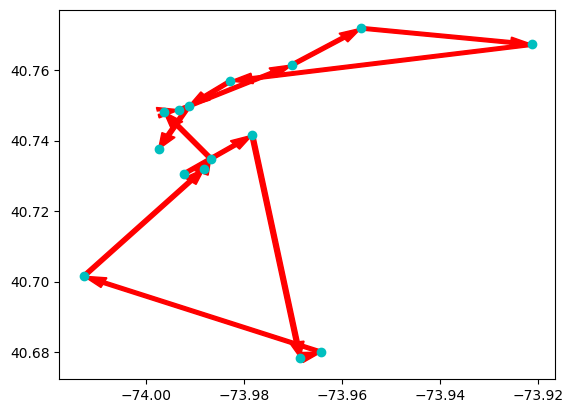

In [20]:
# Plot out the results
x = []
y = []
for point in points:
    x.append(point[0])
    y.append(point[1])
plt.plot(x, y, 'co')

for _ in range(1, len(best_path)):
    i = best_path[_ - 1]
    j = best_path[_]
    plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
              color='r', length_includes_head=True)

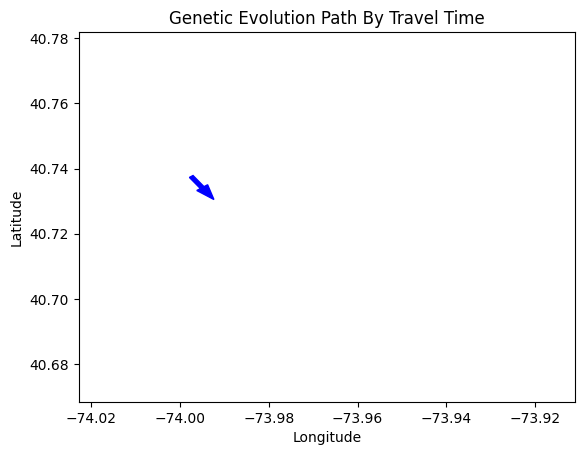

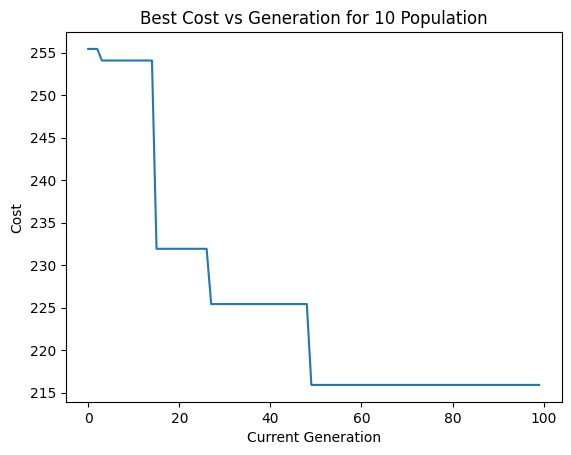

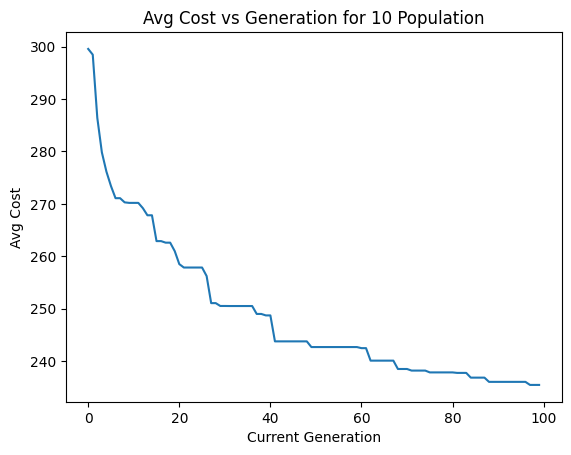

In [21]:
# Close the loop and highlight the last and first point path
i = best_path[-1]  # Last point index
j = best_path[0]  # First point index
plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
          color='b', length_includes_head=True)

zoom_factor = 0.01
plt.xlim(min(x) - zoom_factor, max(x) + zoom_factor)
plt.ylim(min(y) - zoom_factor, max(y) + zoom_factor)
plt.title("Genetic Evolution Path By Travel Time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.title("Best Cost vs Generation for " + str(n) + " Population")
plt.ylabel("Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, y_values)
plt.show()

plt.title("Avg Cost vs Generation for " + str(n) + " Population")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.show()